Portfolio Optimization
Created: 2025.Mar.25

In [64]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize


In [65]:
# 종목 리스트 설정
tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM', 'PG', 'XOM', 'TSLA']

# 일별 종가 데이터 참조 기간 결정
startdate_str = '2020-01-01'
enddate_str = '2024-12-31'


In [66]:

# 3개월 미국 국채 수익률 (^IRX 티커)
rf_data = yf.download('^IRX', period='7d', interval='1d')  # 최근 7일

# 가장 최근의 종가 사용 (단위: %)
latest_rf_percent = rf_data['Close'].dropna().iloc[-1]

# 연간 무위험 수익률로 변환 (소수점 표현)
annual_riskFreeRate = latest_rf_percent / 100

try:
    print(f"Latest 3-Month Treasury Rate (Annual): {annual_riskFreeRate:.4%}")
except:
    latest_rf_percent = rf_data['Close'].dropna().iloc[-1].item() / 100
    annual_riskFreeRate = latest_rf_percent / 100
    print(f"Latest 3-Month Treasury Rate (Annual): {annual_riskFreeRate:.4%}")


[*********************100%***********************]  1 of 1 completed

Latest 3-Month Treasury Rate (Annual): 0.0419%


In [67]:
# 일별 무위험 수익률 계산 (연간 무위험 수익률로부터)
rf_daily__recent = (1 + annual_riskFreeRate)**(1/252) - 1  

In [68]:

# 데이터 다운로드
df = yf.download(tickers, start=startdate_str, end=enddate_str)
# 컬럼 명 확인
print(df.columns)

[*********************100%***********************]  7 of 7 completed

MultiIndex([( 'Close', 'AAPL'),
            ( 'Close',  'JNJ'),
            ( 'Close',  'JPM'),
            ( 'Close', 'MSFT'),
            ( 'Close',   'PG'),
            ( 'Close', 'TSLA'),
            ( 'Close',  'XOM'),
            (  'High', 'AAPL'),
            (  'High',  'JNJ'),
            (  'High',  'JPM'),
            (  'High', 'MSFT'),
            (  'High',   'PG'),
            (  'High', 'TSLA'),
            (  'High',  'XOM'),
            (   'Low', 'AAPL'),
            (   'Low',  'JNJ'),
            (   'Low',  'JPM'),
            (   'Low', 'MSFT'),
            (   'Low',   'PG'),
            (   'Low', 'TSLA'),
            (   'Low',  'XOM'),
            (  'Open', 'AAPL'),
            (  'Open',  'JNJ'),
            (  'Open',  'JPM'),
            (  'Open', 'MSFT'),
            (  'Open',   'PG'),
            (  'Open', 'TSLA'),
            (  'Open',  'XOM'),
            ('Volume', 'AAPL'),
            ('Volume',  'JNJ'),
            ('Volume',  'JPM'),
        

In [69]:
# (멀티레벨 컬럼이므로 'Close'로 접근 후 종목별로 나눔)
# 'Close' 컬럼만 추출 (종가 기준으로 분석하기 위함)
data = df.loc[:, ('Close', slice(None))]

# 컬럼 이름 보기 쉽게 조정 (멀티 인덱스 해제)
data.columns = data.columns.droplevel(0)

print(data.head())

Ticker           AAPL         JNJ         JPM        MSFT          PG  \
Date                                                                    
2020-01-02  72.716057  126.055191  121.477234  153.323242  108.419884   
2020-01-03  72.009117  124.595757  119.874146  151.414139  107.690704   
2020-01-06  72.582901  124.440285  119.778854  151.805481  107.840050   
2020-01-07  72.241539  125.200233  117.742538  150.421387  107.172356   
2020-01-08  73.403656  125.182983  118.661072  152.817337  107.629196   

Ticker           TSLA        XOM  
Date                              
2020-01-02  28.684000  55.137985  
2020-01-03  29.534000  54.694698  
2020-01-06  30.102667  55.114647  
2020-01-07  31.270666  54.663593  
2020-01-08  32.809334  53.839252  


In [70]:
# 결측치 확인
print(data.isnull().sum())


Ticker
AAPL    0
JNJ     0
JPM     0
MSFT    0
PG      0
TSLA    0
XOM     0
dtype: int64


In [71]:

# 결측치가 있다면 forward-fill로 보완
if data.isnull().sum().sum() > 0:
    data = data.ffill()


In [72]:

# 수익률 계산 (일간 수익률)
returns = data.pct_change().dropna()

# 수익률 미리보기
print(returns.head())


Ticker          AAPL       JNJ       JPM      MSFT        PG      TSLA  \
Date                                                                     
2020-01-03 -0.009722 -0.011578 -0.013197 -0.012451 -0.006726  0.029633   
2020-01-06  0.007968 -0.001248 -0.000795  0.002585  0.001387  0.019255   
2020-01-07 -0.004703  0.006107 -0.017001 -0.009118 -0.006192  0.038801   
2020-01-08  0.016087 -0.000138  0.007801  0.015928  0.004263  0.049205   
2020-01-09  0.021241  0.002966  0.003651  0.012493  0.010938 -0.021945   

Ticker           XOM  
Date                  
2020-01-03 -0.008040  
2020-01-06  0.007678  
2020-01-07 -0.008184  
2020-01-08 -0.015080  
2020-01-09  0.007655  


In [73]:

# 수익률 통계요약
print(returns.describe())


Ticker         AAPL          JNJ          JPM         MSFT           PG  \
count   1256.000000  1256.000000  1256.000000  1256.000000  1256.000000   
mean       0.001189     0.000172     0.000745     0.000995     0.000426   
std        0.019962     0.012385     0.020498     0.019217     0.013186   
min       -0.128647    -0.072984    -0.149649    -0.147390    -0.087374   
25%       -0.008426    -0.005728    -0.008412    -0.008248    -0.005545   
50%        0.001210     0.000119     0.000686     0.001113     0.000687   
75%        0.012017     0.005922     0.009903     0.010947     0.006868   
max        0.119808     0.079977     0.180125     0.142169     0.120090   

Ticker         TSLA          XOM  
count   1256.000000  1256.000000  
mean       0.003026     0.000746  
std        0.042325     0.021661  
min       -0.210628    -0.122248  
25%       -0.019882    -0.010940  
50%        0.001912     0.000212  
75%        0.023789     0.012050  
max        0.219190     0.126868  


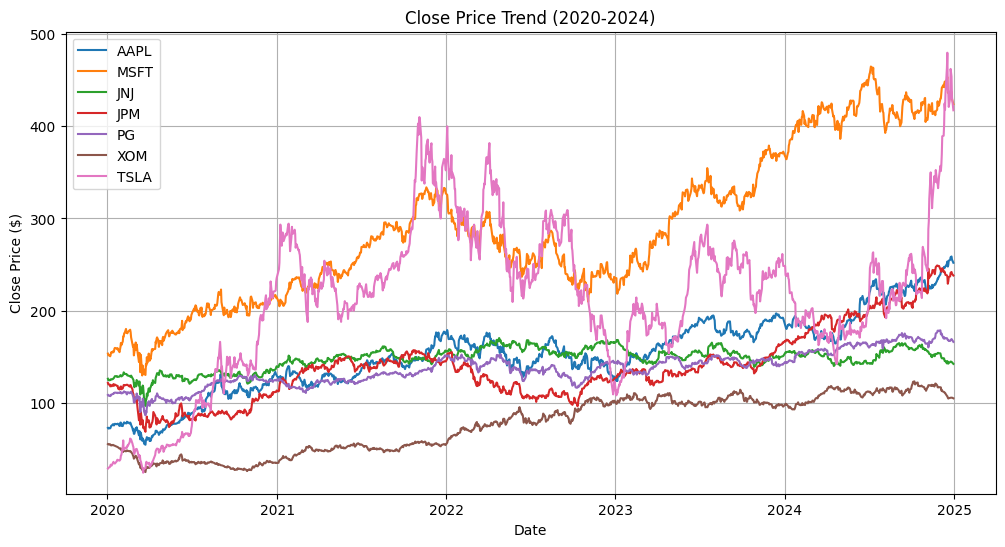

In [ ]:

# ---- 시각화 ----

# 1. 일별 종가 추세 확인 (Price Trend)
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(data.index, data[ticker], label=ticker)
plt.title('Close Price Trend (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid()
plt.show()


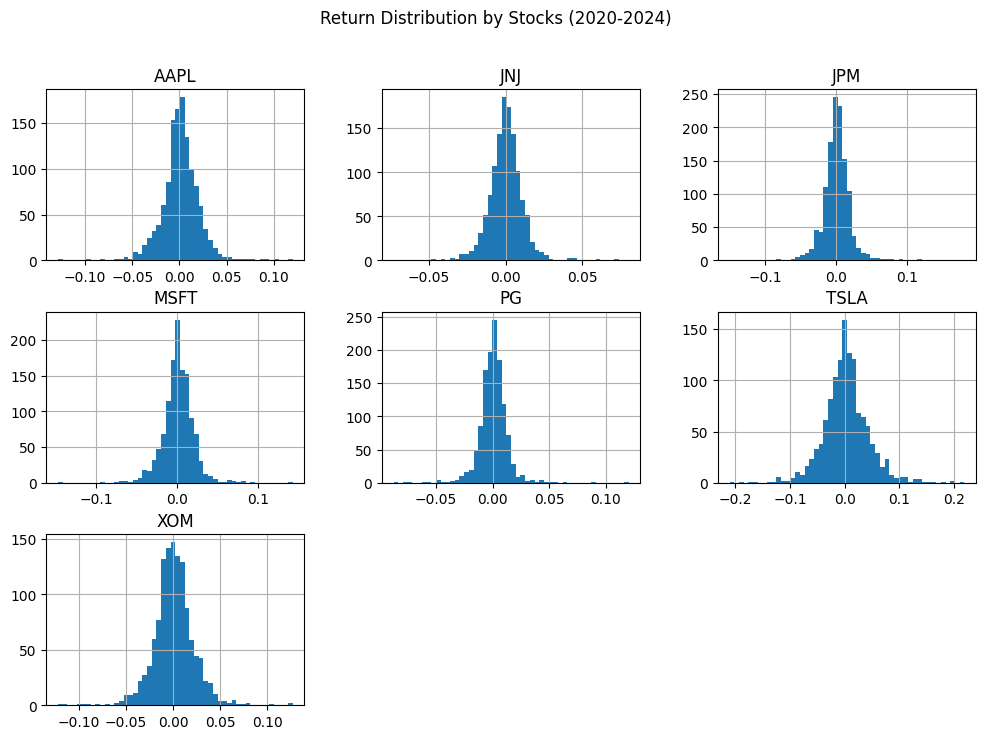

In [75]:

# 2-1. 종목별 수익률 분포 (히스토그램)
returns.hist(bins=50, figsize=(12,8))
plt.suptitle('Return Distribution by Stocks (2020-2024)')
plt.show()


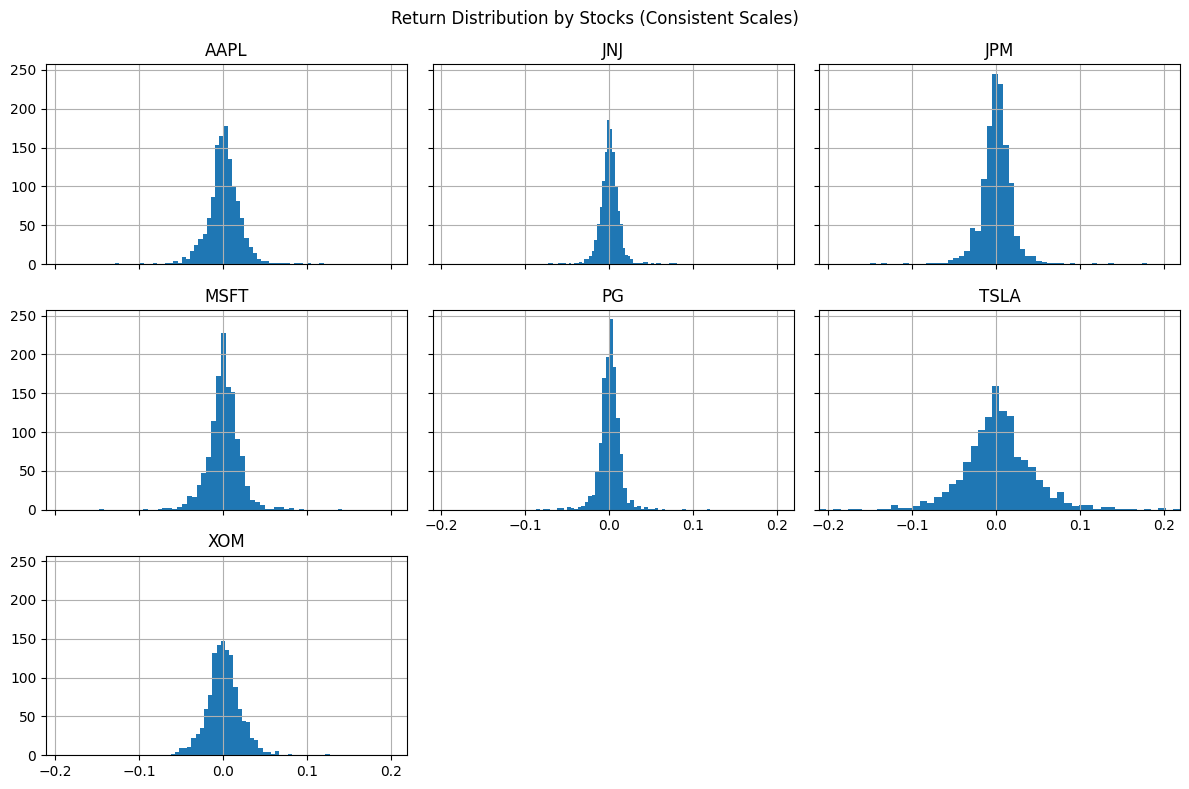

In [76]:
# 2-2. 종목별 수익률 분포 (히스토그램, 축 스케일 통일)

# returns는 이미 계산된 수익률 데이터
axes = returns.hist(bins=50, figsize=(12, 8), sharex=True, sharey=True)

# x축과 y축의 스케일 통일 (범위 강제 지정)
x_min, x_max = returns.min().min(), returns.max().max()
y_max = 0
for ax in axes.flatten():
    y_max = max(y_max, ax.get_ylim()[1])

# 통일된 축 범위 적용
for ax in axes.flatten():
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)

plt.suptitle('Return Distribution by Stocks (Consistent Scales)')
plt.tight_layout()
plt.show()

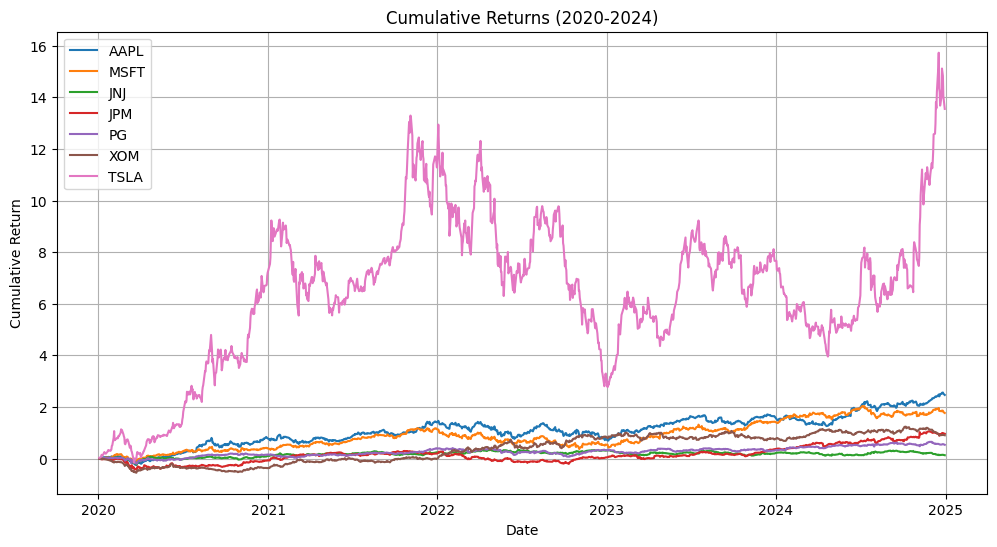

In [77]:

# 3. 종목별 누적 수익률 시각화
cumulative_returns = (1 + returns).cumprod() - 1
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)
plt.title('Cumulative Returns (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()


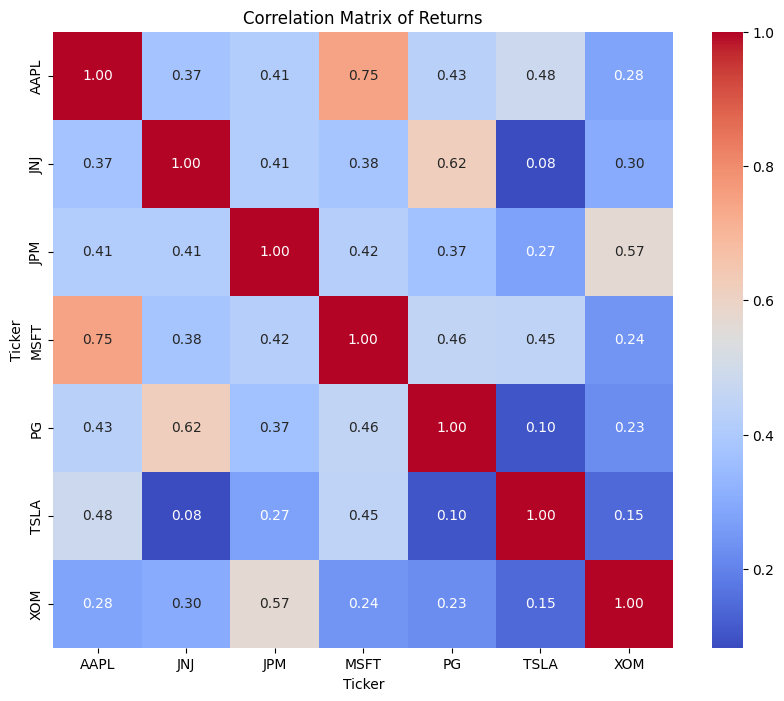

In [78]:

# 4. 상관관계 분석
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Returns')
plt.show()


# Observations #

Strongest Correlation
AAPL–MSFT: 0.748
- These two large-cap tech stocks are highly correlated and tend to move together.
- Including both in a portfolio provides less diversification benefit.

Pairs with Low Correlation (Good for Diversification)
TSLA–JNJ: 0.083
TSLA–PG: 0.102
TSLA–XOM: 0.145
XOM–MSFT: 0.242
- TSLA shows low correlation with most other assets, making it a good candidate for diversification.

Consider combining low-correlation stocks like TSLA, PG, and XOM to maximize diversification.


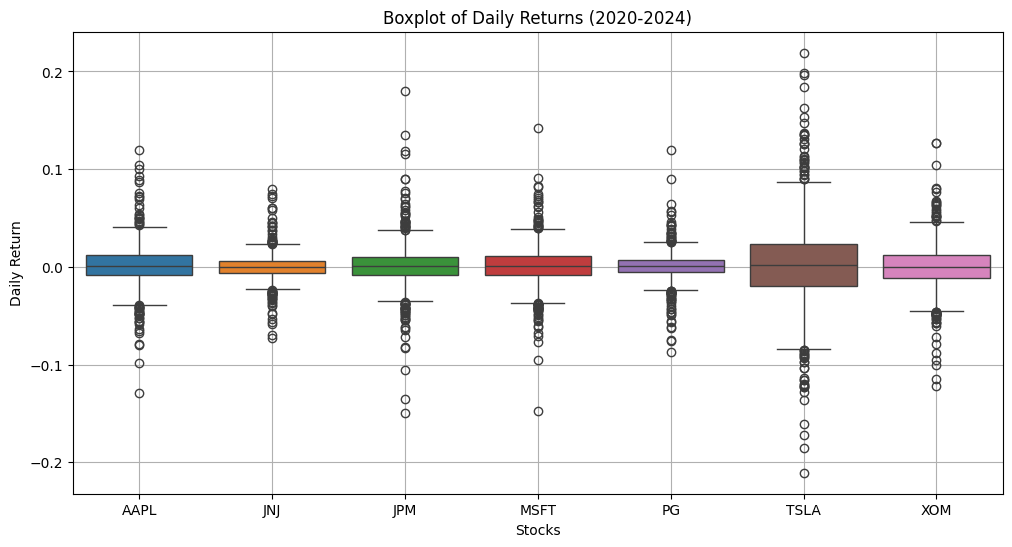

In [79]:

# 5. 종목별 수익률 박스플롯(Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(data=returns)
plt.title('Boxplot of Daily Returns (2020-2024)')
plt.xlabel('Stocks')
plt.ylabel('Daily Return')
plt.grid()
plt.show()

In [80]:
prc_close = df['Close'].ffill()

# 수익률 계산 (daily returns)
returns = prc_close.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_assets = len(tickers)


In [111]:

# 수익률 & 리스크 계산 함수
def portfolio_performance(weights, mean_returns, cov_matrix):
    port_return = np.dot(weights, mean_returns)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_risk


# 최소 분산 포트폴리오 최적화
def min_variance_portfolio(mean_returns, cov_matrix, initialWeights=num_assets * [1. / num_assets]):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    result = minimize(
        lambda w: np.dot(w.T, np.dot(cov_matrix, w)),        # 최소화 대상: 포트폴리오 분산
        initialWeights,                                      # 초기값
        method='SLSQP',                                      # Sequential Least SQuare Programming
        bounds=bounds,
        constraints=constraints
    )
    return result.x


# SLSQP 기반 최적 포트폴리오 계산
optimal_weights = min_variance_portfolio(mean_returns, cov_matrix)
opt_return, opt_risk = portfolio_performance(optimal_weights, mean_returns, cov_matrix)

# Note: SLSQP may provide only a local minimum, instead of the global minimum.
# Initial values in "minimize()" can have an impact on the return value.


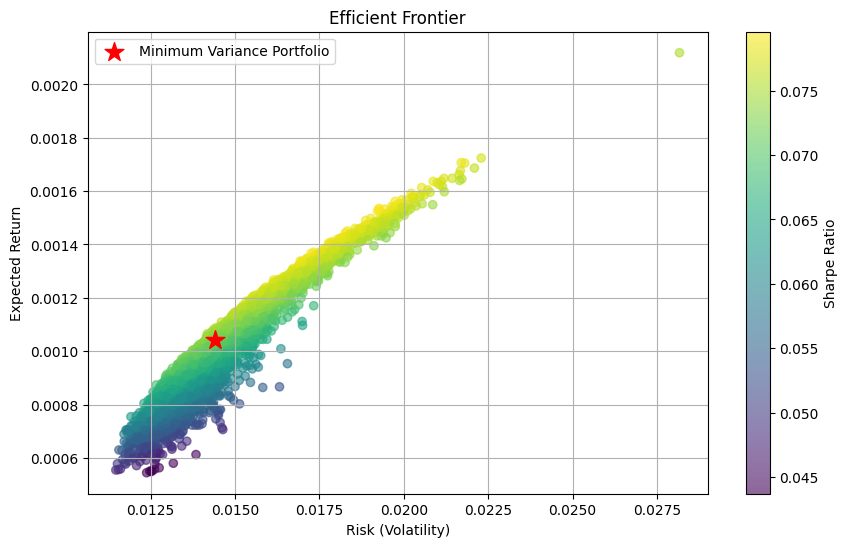

In [112]:

# 샘플 포트폴리오 5,000개 시뮬레이션
weights_list = []
def simulate_random_portfolios(num_portfolios, mean_returns, cov_matrix):
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        ret, risk = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe = (ret - rf_daily__recent) / risk
        results[0, i] = risk
        results[1, i] = ret
        results[2, i] = sharpe
        weights_list.append(weights)
    return results

results = simulate_random_portfolios(5000, mean_returns, cov_matrix)

# 효율적 투자선 시각화
plt.figure(figsize=(10, 6))
plt.scatter(results[0], results[1], c=results[2], cmap='viridis', alpha=0.6)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.scatter(opt_risk, opt_return, c='red', marker='*', s=200, label='Minimum Variance Portfolio')
plt.legend()
plt.grid(True)
plt.show()

Note: The minimum variance portfolio does not have the least variance!

Other initial values in min_variance_portfolio(mean_returns, cov_matrix, initialWeights) shall be tested to find the true minimum variance portfolio.

In [113]:
# Determine best portfolios at each risk level
portfolios = pd.DataFrame({
    'Risk': results[0],
    'Return': results[1],
    'Sharpe': results[2]
})
for i, ticker in enumerate(tickers):
    portfolios[ticker] = [w[i] for w in weights_list]

# 리스크의 소숫점 세째자리까지를 기준으로 구간을 나눔
portfolios['RiskBucket'] = (portfolios['Risk'] * 1000).astype(int)

# 각 리스크 구간에서 수익률이 가장 높은 포트폴리오만 추출
efficient_set = portfolios.loc[portfolios.groupby('RiskBucket')['Return'].idxmax()].reset_index(drop=True)


In [114]:
efficient_set.head()

,Risk,Return,Sharpe,AAPL,MSFT,JNJ,JPM,PG,XOM,TSLA,RiskBucket
0,0.011919,0.000754,0.063153,0.099116,0.286859,0.005404,0.064780,0.286037,0.089644,0.168160,11
1,0.012978,0.000913,0.070214,0.115164,0.281476,0.019911,0.025833,0.249804,0.153876,0.153936,12
2,0.013977,0.001026,0.073262,0.131542,0.218069,0.070610,0.015482,0.218187,0.180913,0.165197,13
3,0.014972,0.001143,0.076203,0.171051,0.170108,0.015233,0.059895,0.243530,0.211171,0.129012,14
4,0.015905,0.001240,0.077835,0.196963,0.037525,0.029856,0.097372,0.226483,0.208845,0.202955,15


In [115]:
# simulated portfolios with small variance
smallVarianceWeights = efficient_set.iloc[0,3:-1].values
smallVarianceWeights

array([0.09911585, 0.28685886, 0.00540421, 0.06477973, 0.2860373 ,
       0.08964387, 0.16816019])

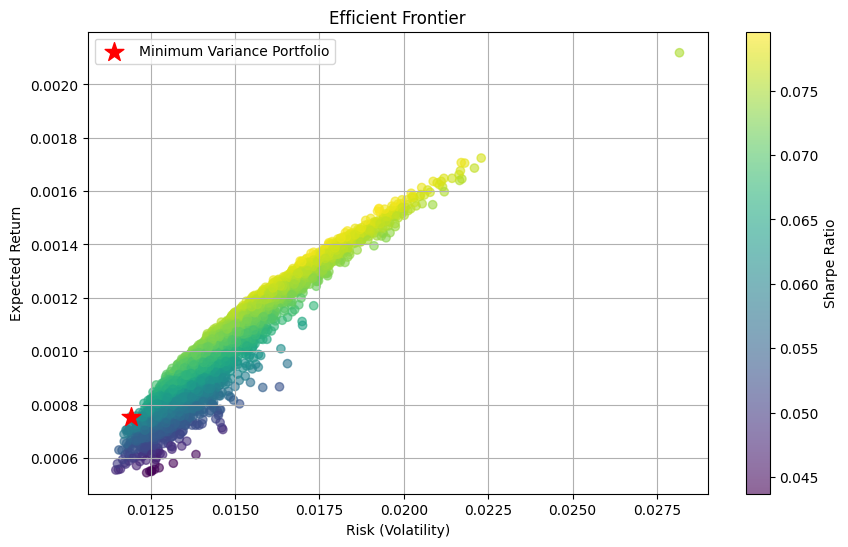

In [ ]:
# Determine the minimum variance portfolio again with corrected initial weights

# SLSQP 기반 최적 포트폴리오 계산 (minimize() 내 초기값을 smallVarianceWeights로 수정)
optimal_weights_corrected = min_variance_portfolio(mean_returns, cov_matrix, smallVarianceWeights)
opt_return_corrected, opt_risk_corrected = portfolio_performance(optimal_weights_corrected, mean_returns, cov_matrix)


# 수정된 최소 분산 포트폴리오 시각화
plt.figure(figsize=(10, 6))
plt.scatter(results[0], results[1], c=results[2], cmap='viridis', alpha=0.6)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.scatter(opt_risk_corrected, opt_return_corrected, c='red', marker='*', s=200, label='Minimum Variance Portfolio')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Export best portfolios
efficient_set.to_csv("efficient_frontier_portfolios.csv", index=False)

5000

In [ ]:
# # 과거의 Sharpe ratio가 필요한 경우
# # 무위험 수익률 기준을 과거 RiskFree 시계열 데이터 기준으로 변경

# import pandas_datareader.data as web
# import datetime

# # 날짜 범위 설정
# start = datetime.datetime(2020, 1, 1)
# end = datetime.datetime(2024, 12, 31)

In [ ]:
# # 무위험 수익률 데이터 다운로드 (FRED - 3개월 T-Bill 수익률)
# rf_monthly = web.DataReader('TB3MS', 'fred', start, end)
# rf_monthly = rf_monthly.fillna(method='ffill') / 100  # % -> 소수점

# # 월간 → 일간 리샘플링 및 수익률 단위 맞추기
# rf_daily = rf_monthly.resample('D').ffill()
# rf_daily = rf_daily.reindex(returns.index)
# daily_rf = (1 + rf_daily) ** (1 / 252) - 1
# daily_rf.columns = ['Daily_RF']

# # 수익률과 무위험 수익률 병합
# returns_with_rf = returns.copy()
# returns_with_rf['RiskFree'] = daily_rf['Daily_RF']

# # 확인
# print(returns_with_rf.head())

Ticker          AAPL       JNJ       JPM      MSFT        PG      TSLA  \
Date                                                                     
2020-01-03 -0.009722 -0.011578 -0.013197 -0.012451 -0.006726  0.029633   
2020-01-06  0.007968 -0.001248 -0.000795  0.002585  0.001387  0.019255   
2020-01-07 -0.004703  0.006107 -0.017001 -0.009118 -0.006192  0.038801   
2020-01-08  0.016087 -0.000138  0.007801  0.015928  0.004263  0.049205   
2020-01-09  0.021241  0.002966  0.003651  0.012493  0.010938 -0.021945   

Ticker           XOM  RiskFree  
Date                            
2020-01-03 -0.008040   0.00006  
2020-01-06  0.007678   0.00006  
2020-01-07 -0.008184   0.00006  
2020-01-08 -0.015080   0.00006  
2020-01-09  0.007655   0.00006  
